created_at
2025-05-22 00:00:00+00:00          0.0
2025-05-23 00:00:00+00:00          0.0
2025-05-24 00:00:00+00:00          0.0
2025-05-25 00:00:00+00:00          0.0
2025-05-26 00:00:00+00:00          0.0
2025-05-27 00:00:00+00:00          0.0
2025-05-28 00:00:00+00:00          0.0
2025-05-29 00:00:00+00:00          0.0
2025-05-30 00:00:00+00:00          0.0
2025-05-31 00:00:00+00:00    2646391.0
Freq: D, Name: views_count, dtype: float64


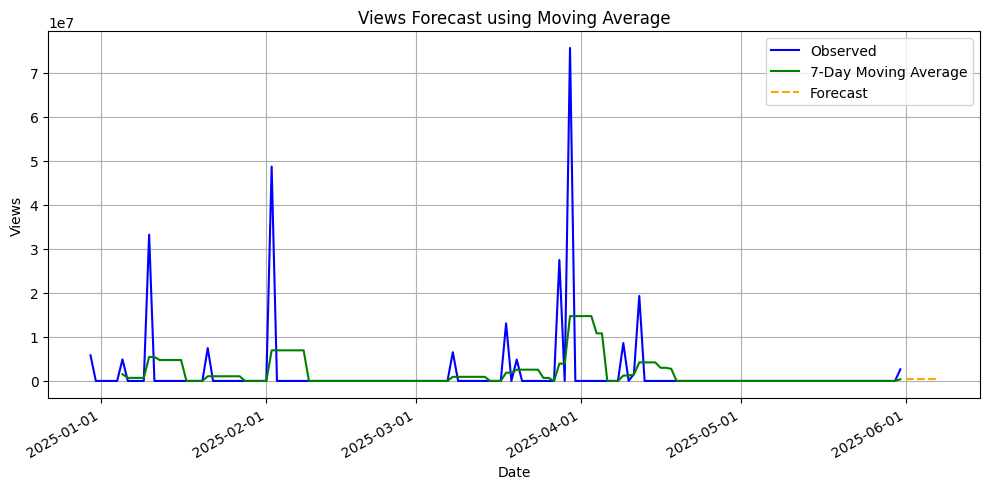

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Load and prepare data
df = pd.read_csv("ishowspeed_tweets.csv")
df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %z %Y")
df.set_index("created_at", inplace=True)
df.sort_index(inplace=True)

# Resample to daily average views
daily_views = df["views_count"].resample("D").mean().fillna(0)
# print(daily_views.tail(10))

# Calculate moving average (e.g., 7-day rolling mean)
rolling_avg = daily_views.rolling(window=7).mean()

# Forecast: assume last rolling avg value continues for next 7 days
last_value = rolling_avg.dropna().iloc[-1]
forecast = [last_value] * 7
forecast_dates = pd.date_range(start=daily_views.index[-1] + timedelta(days=1), periods=7)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_views.index, daily_views, label="Observed", color="blue")
plt.plot(rolling_avg.index, rolling_avg, label="7-Day Moving Average", color="green")
plt.plot(forecast_dates, forecast, linestyle="--", label="Forecast", color="orange")

# Fix date formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()

plt.title("Views Forecast using Moving Average")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Train a classifier for future tweet performance
# Can be removed if uneccessary
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load data
df = pd.read_csv("ishowspeed_tweets.csv")

# Label viral tweets
df["is_viral"] = df["views_count"] > df["views_count"].median()

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=["content_type", "sentiment_label", "media_type"])

# Drop unused or non-numeric columns
features = df.drop(columns=["created_at", "text", "media_url", "quote_topics", "is_viral"])
label = df["is_viral"]

feature_columns = features.columns 

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)
model = RandomForestClassifier().fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))

Accuracy: 1.0


In [ ]:
# with the RapidAPI Twttr API, only the recent 16 tweets of ISHowSpeed was able to be collected
# and IShowSpeed did not post any tweets in May, and only 1 tweet in Jun (1 June)
# Hence, leading to sparse data:
# If some recent days have no tweets, daily_views for those days becomes gets filled with 0 (due to .fillna(0) logic)
# This would artificially drag the average down
# If the last 7 values are repeated (e.g., all zero or same small value), then moving average remains constant

# Tried using ARIMA but there is too few data to analyse

In [28]:
# Extract countries mentioned in ishowspeed's tweets
import pycountry

# Load and prepare data
df = pd.read_csv("ishowspeed_tweets.csv")

# Filter tweets with "travel" in the content_type
travel_df = df[df["content_type"].str.contains("travel", case=False, na=False)].copy()

country_names = [country.name.lower() for country in pycountry.countries]

def extract_country_mentions(text):
    text = text.lower()
    for country in country_names:
        if country in text:
            return country
    return None

travel_df.loc[:, "mentioned_country"] = travel_df["text"].apply(extract_country_mentions)

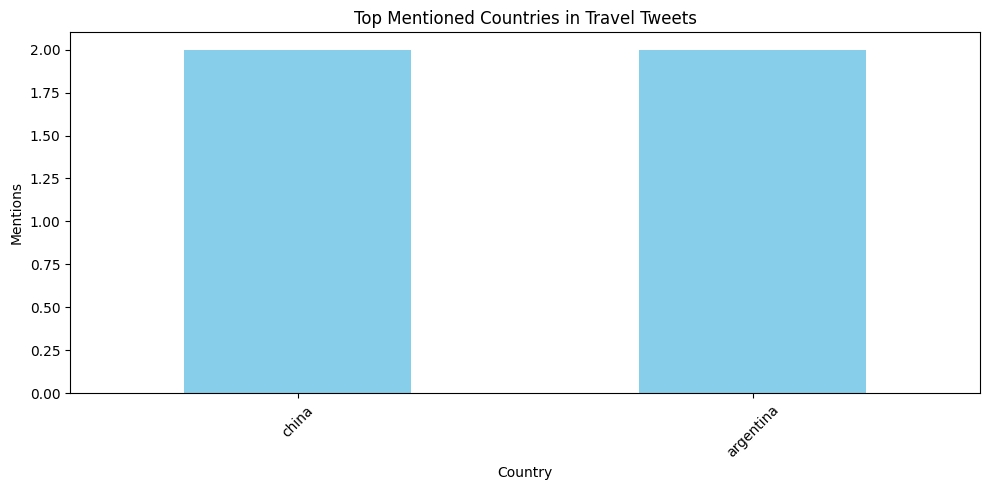

In [30]:
import matplotlib.pyplot as plt

# From tweets
top_tweet_countries = travel_df["mentioned_country"].value_counts().head(10)

# Plot
plt.figure(figsize=(10,5))
top_tweet_countries.plot(kind="bar", color="skyblue")
plt.title("Top Mentioned Countries in Travel Tweets")
plt.xlabel("Country")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# There is also a few tweets where he mentioned South America (a continent), to which he has travelled to most countries in the South America continent

In [29]:
# Extract countries mentioned in quotes
from collections import Counter

# Load all sheets from the cleaned Excel file
cleaned_quotes = pd.read_excel("ishowspeed_quotes.xlsx", sheet_name=None)

# Count countries across all sheets
country_counter = Counter()

for sheet_name, df in cleaned_quotes.items():
    if "translated_text" in df.columns:
        countries = df["translated_text"].apply(extract_country_mentions)
        country_counter.update(c for c in countries if c)

# Display top mentioned countries
print(country_counter.most_common(10))

[('china', 13), ('argentina', 9), ('india', 2), ('colombia', 2), ('uruguay', 2), ('mongolia', 1), ('bulgaria', 1), ('guatemala', 1), ('brazil', 1)]


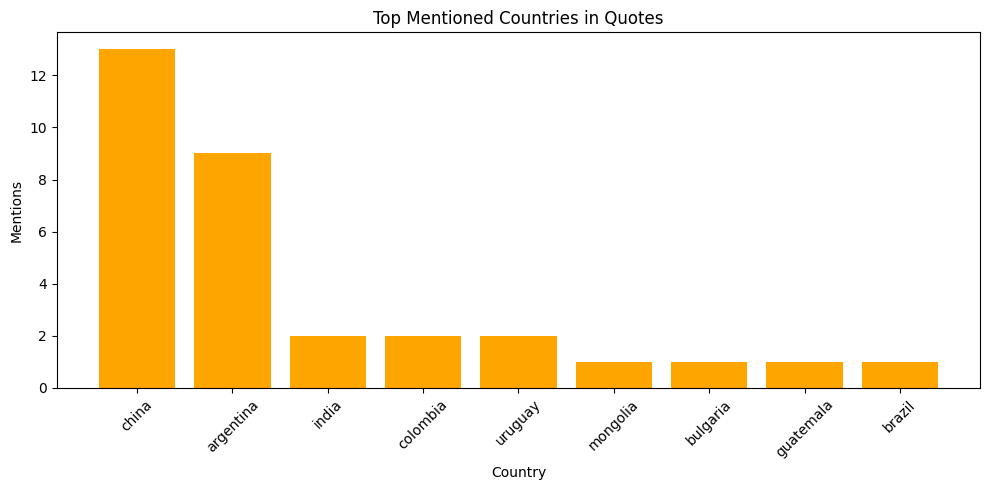

In [31]:
# Take top 10
top_countries = dict(country_counter.most_common(10))

plt.figure(figsize=(10, 5))
plt.bar(top_countries.keys(), top_countries.values(), color="orange")
plt.title("Top Mentioned Countries in Quotes")
plt.xlabel("Country")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ISHowSpeed has been to China, Mongolia, Argentina, India, and South America countries such as Colombia, Uruguay, Brazil, Guatemala, Bulgaria
# So all countries mentioned in the quotes are countries which he has been to
# Speed might travel to another country in the Asia continent, like Russia, Kazakhstan, or he might go to Venezuela since he did not go there when he went to South America